# Interpolation
___

**Remarks**
- Code will need to be modified a bit to reflect the use of a certain group of data instead of all data

In [100]:
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from itertools import combinations

# from scipy.spatial.distance import pdist
# from scipy.stats import chisquare, chi2
from scipy.stats import ttest_1samp, t

from pykrige.ok import OrdinaryKriging
from pykrige.rk import Krige
import pykrige.kriging_tools as kt

from sklearn.model_selection import cross_val_predict

from joblib import Parallel, delayed
import multiprocessing

In [101]:
import prepostprocessing.pre_processing as preproc
import prepostprocessing.post_processing as postproc
import nugget_estimation.kriging_tools as krigingtools
import nugget_estimation.detrending as detrending
import plots.plots as plots
import prepostprocessing.cleaning as cleaning
import cross_validation.leave_one_out_cross_validation as loocv

import qapf.qapf as qapf
import statistics.ttest as ttest
import statistics.simulations as sim

import toolbox.toolbox as tb

In [102]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readtheMLcs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# You only need to run this cell once if you want to have multiple outputs in all your notebooks.
# It is a general setting so you can set this cell's status to 'raw'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [104]:
coordinates_latlon = preproc.load_obj("coordinates_area1_Tr_J")
coordinates_utm = preproc.load_obj("coordinates_utm_area1_Tr_J")
mineralogy = preproc.load_obj("mineralogy_area1_Tr_J")
mineralogy_clr = preproc.load_obj("mineralogy_clr_area1_Tr_J")
mineralogy_pca = preproc.load_obj("mineralogy_pca_area1_Tr_J")
mineralogy_pca_df = preproc.load_obj("mineralogy_pca_area1_Tr_J_df")
metadata = preproc.load_obj("metadata_area1_Tr_J")

## EDA
___

In [105]:
# Get number of control points that will be used
number_of_control_points = coordinates_utm.shape[0]
number_of_control_points

298

In [106]:
coordinates_utm

,Y_UTM,X_UTM,ZoneNumber,ZoneLetter
35,7.594764e+05,5.704626e+06,48,U
36,9.420864e+05,5.760143e+06,48,U
65,1.198609e+06,6.024470e+06,48,U
73,8.570216e+05,5.795547e+06,48,U
124,8.529822e+05,5.861658e+06,48,U
...,...,...,...,...
3987,1.043731e+06,5.826313e+06,48,U
4014,1.329009e+06,6.046216e+06,48,U
4078,1.122917e+06,6.025539e+06,48,U
4220,1.337610e+06,6.094699e+06,48,U


In [107]:
coordinates_utm = coordinates_utm.rename({"X_UTM": "Y", "Y_UTM": "X"}, axis=1)

In [108]:
# FILL IN SHORT NAME HERE THAT WILL BE USED WHEN SAVING THE PLOT (e.g. "G1")
group_name = "area1_Tr_J"

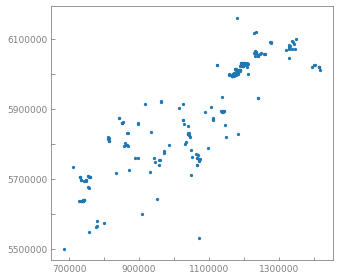

In [109]:
# Plot control points with labels
plots.plot_map_with_control_points(coordinates_utm, group_name, label_size=4, subset=["X", "Y"],
                                   show_labels=False,
                                  skip_xaxis_label=2, skip_yaxis_label=2, 
                                  skip_xaxis_start=1, skip_yaxis_start=1)

In [110]:
# Show unique zone letters and zone numbers of utm coordinates
coordinates_utm["ZoneNumber"].unique()
coordinates_utm["ZoneLetter"].unique()

array([48], dtype=int64)

array(['U'], dtype=object)

In [111]:
# Calculate minimum and maxmin lag distance between two points of the dataset
distance_matrix = krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm[["X", "Y"]])

min_lag_distance = np.amin(distance_matrix)
max_lag_distance = np.amax(distance_matrix)
min_lag_distance, max_lag_distance

(0.0018036039928465838, 895384.3276935855)

(array([9370., 6912., 3736., 3084., 3872., 3108., 3994., 3098., 3418.,
        3786., 3422., 3444., 2448., 2908., 2452., 3260., 2852., 2204.,
        2202., 1726., 1008., 1102., 1274., 2212., 2166., 3102., 1696.,
        1400.,  516.,  594.,  346.,  536.,  448.,  430.,  260.,   58.,
          14.,   10.,   14.,   24.]),
 array([1.80360399e-03, 2.23846100e+04, 4.47692181e+04, 6.71538262e+04,
        8.95384344e+04, 1.11923043e+05, 1.34307651e+05, 1.56692259e+05,
        1.79076867e+05, 2.01461475e+05, 2.23846083e+05, 2.46230691e+05,
        2.68615300e+05, 2.90999908e+05, 3.13384516e+05, 3.35769124e+05,
        3.58153732e+05, 3.80538340e+05, 4.02922948e+05, 4.25307557e+05,
        4.47692165e+05, 4.70076773e+05, 4.92461381e+05, 5.14845989e+05,
        5.37230597e+05, 5.59615205e+05, 5.81999814e+05, 6.04384422e+05,
        6.26769030e+05, 6.49153638e+05, 6.71538246e+05, 6.93922854e+05,
        7.16307463e+05, 7.38692071e+05, 7.61076679e+05, 7.83461287e+05,
        8.05845895e+05, 8.2823

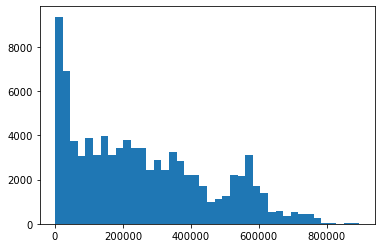

In [112]:
plt.hist(distance_matrix.flatten(), bins=40)

In [113]:
np.where(distance_matrix == 0)

(array([], dtype=int64), array([], dtype=int64))

## Critical distance estimation
___

In [114]:
# Range (lag distance at which the sill is reached; in meters)

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.

# Modified the range since variograms are not correct yet
# range_ = [100000] * 15
range_ = [52000, 52000, 52000, 52000, 52000, 52000, 52000, 52000, 52000, 100000, 100000, 100000, 100000, 100000, 100000]



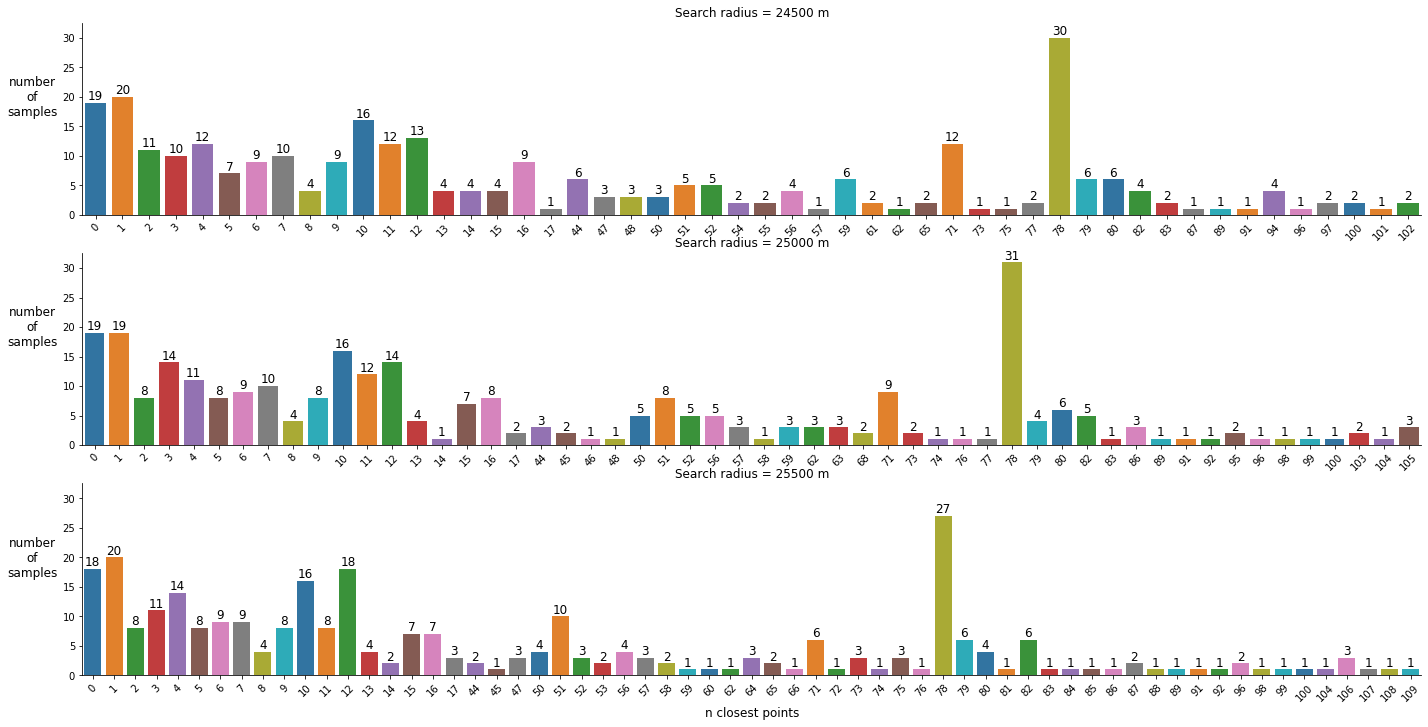

In [115]:
# You can adjust the radius parameters below to change the slider settings
# to visualize the figures interactively
plots.interactive_plot_search_radius(coordinates_utm, orient='rows', 
                                     radius_default=25000, # Default slider position
                                     radius_min=20000,  # Slider start
                                     radius_max=40000, # Slider stop
                                     radius_step=500,  # Slider step
                                     radius_offset=500) # Offset between visualizations shown

# The x-axis stands for 'n_neighbours'

In [116]:
# Critical distance (in meters)
# This is the distance where at least 95% of your samples
# will have at least 3 neighbours within that distance

# You can refine this value later on, or we can use the range 
# instead of the critical distance as the only value for the search radius
critical_distance = 51000

In [117]:
# This is basically creating a list of how many neighbours each data point has 
# within the critical_distance and within the range
nvalues_control_points = {}

for radius in (0.05, critical_distance, range_[0]):
    temp = krigingtools.find_points_within_search_radius(
               krigingtools.calculate_and_sort_square_distance_matrix(coordinates_utm),
               search_radius=radius # 'search_radius' should be equal to 'radius' here, not 'critical_distance'
           )
    nvalues_control_points[radius] = pd.Series(temp, index=coordinates_utm.index)
    
# You're performing a calculation in a for loop so we want to check how many neighbours each data point has 
# within the specified radius in the tuple (0.05, critical_distance, range_[0]). 
# So for each of these specified distances, the function will be executed and 
# the result stored in the nvalues_control_points dictionary

In [118]:
# Number of samples that may still have less than 3 neighbours within the critical distance
number_of_control_points * 0.05

14.9

In [119]:
# Check number of samples outside of critical distance
samples_outside_critical_distance = nvalues_control_points[critical_distance][nvalues_control_points[critical_distance] < 3].index.tolist()
len(samples_outside_critical_distance)

# It's 0.05 sample above 72.95

15

In [120]:
# Overview of samples that are outside search_radius
mineralogy_pca_df.loc[samples_outside_critical_distance, :]

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,PC11
168,-1.117589,1.219399,-0.600482,0.721450,0.318724,-0.818074,-0.389029,0.065351,0.124177,0.041316,-4.535403e-16
435,-0.137821,-0.685181,0.455501,2.326153,-0.360334,1.129967,-0.515567,0.001951,0.202428,0.020822,-2.455408e-16
742,-1.538846,-1.045943,-0.405087,-0.160520,-0.157946,-0.604801,0.181398,0.135519,0.048484,0.105078,5.890858e-17
967,-0.517492,-0.191584,-0.366119,0.359624,-1.150140,-0.544221,0.021268,-0.031892,0.035735,0.090748,-7.513686e-17
1024,-0.278250,-0.019867,-0.012376,0.490559,-0.476413,-0.104797,0.060951,-0.173619,0.101616,-0.001743,-8.030420e-17
1158,0.048270,0.060479,-0.413863,-0.203768,-0.320538,-0.072508,0.390654,-0.481675,0.047987,0.019858,6.721375e-17
1536,0.643819,0.140129,0.473555,-0.609443,-0.461738,-0.271654,0.090244,-0.284260,0.063908,0.015015,2.340660e-16
1704,0.573743,-0.318650,0.243024,-0.863860,0.041970,0.195145,0.178062,-0.081312,0.020656,0.018522,3.562446e-16
1760,1.010627,-0.042920,0.003932,-1.694439,-0.428329,-0.730752,-0.166794,-0.352012,0.386480,-0.085882,5.047454e-16
1937,-0.234744,-1.554631,-0.685431,0.061297,-0.006910,-0.128085,0.068538,0.039307,0.060383,0.093623,-1.019559e-17


____

## Create high resolution grids
____

In [121]:
# Determine (wide) grid boundaries
X = coordinates_utm.iloc[:, 0].values
Xmin = np.min(X) - critical_distance * 1.05
Xmax = np.max(X) + critical_distance * 1.05

Y = coordinates_utm.iloc[:, 1].values
Ymin = np.min(Y) - critical_distance * 1.05, 
Ymax = np.max(Y) + critical_distance * 1.05

coordinates_boundaries = np.array([[Xmin, Xmax], [Ymin, Ymax]])
coordinates_boundaries

array([[630954.9837446201, 1471209.094069415],
       [(5446889.705348704,), 6214275.412412549]], dtype=object)

In [122]:
# Set approximate number of points along each axis
n_points = 450

temp = {}
x, y = coordinates_boundaries

temp["x_start (m)"] = int(np.floor(x[0]))
temp["x_end (m)"] = int(np.floor(x[1]))
temp["y_start (m)"] = int(np.floor(y[0]))
temp["y_end (m)"] = int(np.floor(y[1]))

print("x", x)
print("y", y)

temp["x_range (m)"] = int(np.floor(x[1])) - int(np.floor(x[0]))
temp["y_range (m)"] = int(np.floor(y[1])) - int(np.floor(y[0]))
print("x range: ", temp["x_range (m)"])
print("y range: ", temp["y_range (m)"])

ranges = {"x": temp["x_range (m)"],
          "y": temp["y_range (m)"],
         }

threshold = 10000000
for dimension, ranger in ranges.items():
    if ranger < threshold:
        smallest_dimension = dimension
        threshold = ranger
print("smallest dimension", smallest_dimension)

x_spacing, dx = np.linspace(x[0], x[1], n_points, retstep=True)
y_spacing, dy = np.linspace(y[0], y[1], n_points, retstep=True)

steps = {"x": dx,
         "y": dy,
        }

print("theoretical x spacing: ", dx)

xgrid = np.arange(x[0]-dx, x[1]+dx, steps[smallest_dimension])
ygrid = np.arange(y[0]-dy, y[1]+dy, steps[smallest_dimension])

print("actual x spacing: ", xgrid[1] - xgrid[0])
print("actual y spacing: ", ygrid[1] - ygrid[0])

temp["x_spacing (m)"] = np.round(xgrid[1] - xgrid[0], 2)
temp["y_spacing (m)"] = np.round(ygrid[1] - ygrid[0], 2)

print("Number of points: ", len(xgrid) * len(ygrid))
print("xy grid: ", len(xgrid), len(ygrid), "\n")

temp["#xgrid_points"] = len(xgrid)
temp["#ygrid_points"] = len(ygrid)
temp["#total_grid_nodes"] = len(xgrid) * len(ygrid)

coordinates_grids = [xgrid, ygrid]
coordinates_grids_details = temp

# Assigned to a different variable (name) because later on 'grid' gets used in the code
grid = coordinates_grids

x [630954.9837446201 1471209.094069415]
y [(5446889.705348704,) 6214275.412412549]
x range:  840255
y range:  767386
smallest dimension y
theoretical x spacing:  1871.390000723374
actual x spacing:  1709.0995702981018
actual y spacing:  1709.099570297636
Number of points:  222794
xy grid:  494 451 



## Classification map
___

We will have to decide on a certain classification scheme before we could use this.  
Another option might be to use a condensed version of the 'type_granite' column.

**Yep**

## Detrending
____

In [123]:
# Check if there is a trend present in the data
# This is the case if R² is above say 0.70 

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    for order in [1, 2]:
        print("R² for", component, "order =", order, ":")
        detrending.detrend(coordinates_utm, 
                           mineralogy_pca_df[component], 
                           order=order, 
                           verbose=False, 
                           plot_points=False)[1]

R² for PC01 order = 1 :


0.026385869017136576

R² for PC01 order = 2 :


0.09895061989747422

R² for PC02 order = 1 :


0.016868101564966875

R² for PC02 order = 2 :


0.027239568524143

R² for PC03 order = 1 :


0.0956641627988083

R² for PC03 order = 2 :


0.11762871077176207

R² for PC04 order = 1 :


0.01959716919463228

R² for PC04 order = 2 :


0.030176495910013035

R² for PC05 order = 1 :


0.0027879189617472377

R² for PC05 order = 2 :


0.01174736820916078

R² for PC06 order = 1 :


0.0553322667253181

R² for PC06 order = 2 :


0.06817229241433687

R² for PC07 order = 1 :


0.1600451020158955

R² for PC07 order = 2 :


0.2152862469341208

R² for PC08 order = 1 :


0.0016529096032922297

R² for PC08 order = 2 :


0.008632438163064027

R² for PC09 order = 1 :


0.02450847650974397

R² for PC09 order = 2 :


0.044502582424518655

R² for PC10 order = 1 :


0.009913530438337204

R² for PC10 order = 2 :


0.010247971294531255

## Variogram modelling
___

* Variogram model (str)
* Sill (float)
* Range (float)
* Nugget (float)
* Number of lag bins (int)
* Weighted (Bool)

In [124]:
# Nugget (variance at lag=0 metric)

# Since we are not dealing with point count data here,
# we can not use the formulas from our paper we have talked about
# Therefore I would just start with nugget=0 and perhaps later change this

# Depending on how many principal components you will use, 
# you will have to add more entries to this list.
nugget_ = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,]

In [125]:
PC_nr_list = [nr[2:] for nr in mineralogy_pca_df.columns]
PC_nr_list

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']

In [126]:
# Sill (total variance metric)

# A 'list comprehension' construction is used here
sill_ = [mineralogy_pca_df.loc[:, f"PC{i}"].values.var(ddof=1) 
         for i in PC_nr_list]

In [127]:
# Variogram model parameters dictionary

variogram_model_parameters = {}

for i, PC in enumerate(mineralogy_pca_df.columns):
    parameters = {}
    parameters["sill"] = sill_[i]
    parameters["range"] = range_[i]
    parameters["nugget"] = nugget_[i]
        
    variogram_model_parameters[PC] = parameters

In [128]:
# Variogram model

# You can choose between ["exponential", "linear", "spherical", "power", "gaussian"]
# see https://pykrige.readthedocs.io/en/latest/variogram_models.html for equations
variogram_model = "exponential"

In [129]:
# Number of lag bins

n_lags = int(np.floor(np.sqrt(coordinates_utm.shape[0])))
n_lags

17

In [130]:
# Set utm coordinates to use in variogram

X = coordinates_utm.iloc[:, 0].values
Y = coordinates_utm.iloc[:, 1].values

PC01
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.7602947307574239
Full Sill: 0.7602947307574239
Range: 52000
Nugget: 0.0 



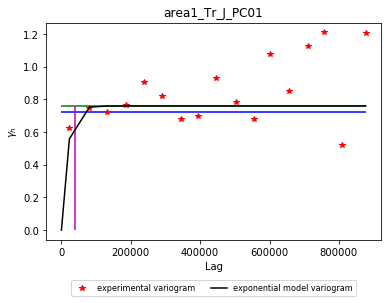

Calculating statistics on variogram model fit...
PC02
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.5216228174508784
Full Sill: 0.5216228174508784
Range: 52000
Nugget: 0.0 



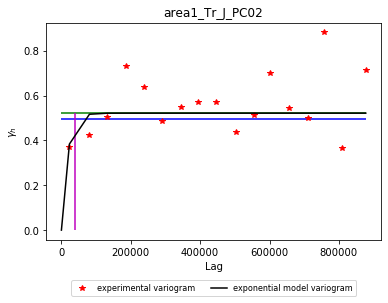

Calculating statistics on variogram model fit...
PC03
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.3224096120051645
Full Sill: 0.3224096120051645
Range: 52000
Nugget: 0.0 



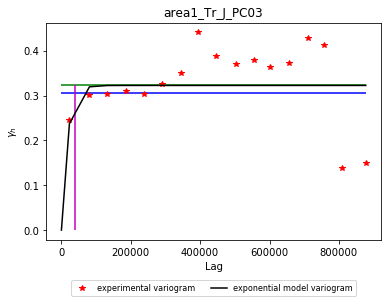

Calculating statistics on variogram model fit...
PC04
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.2585456524070918
Full Sill: 0.2585456524070918
Range: 52000
Nugget: 0.0 



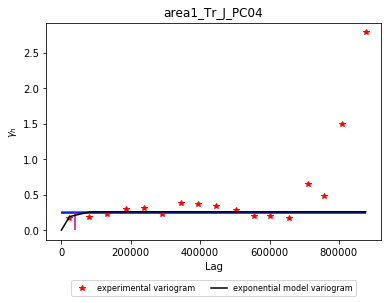

Calculating statistics on variogram model fit...
PC05
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.2222436503119177
Full Sill: 0.2222436503119177
Range: 52000
Nugget: 0.0 



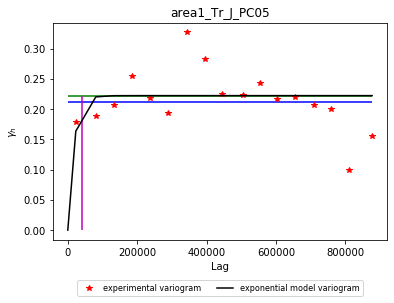

Calculating statistics on variogram model fit...
PC06
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.20203315047676826
Full Sill: 0.20203315047676826
Range: 52000
Nugget: 0.0 



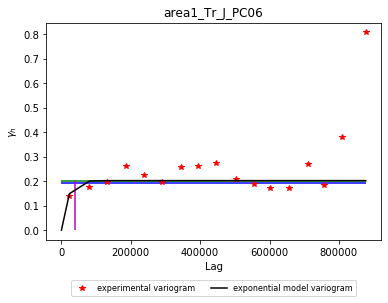

Calculating statistics on variogram model fit...
PC07
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.12309486517314168
Full Sill: 0.12309486517314168
Range: 52000
Nugget: 0.0 



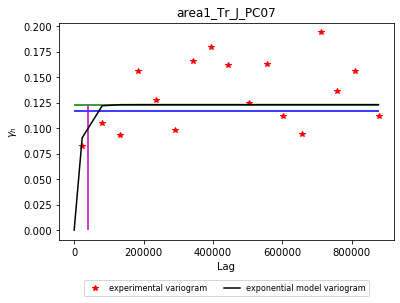

Calculating statistics on variogram model fit...
PC08
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.019327224609395396
Full Sill: 0.019327224609395396
Range: 52000
Nugget: 0.0 



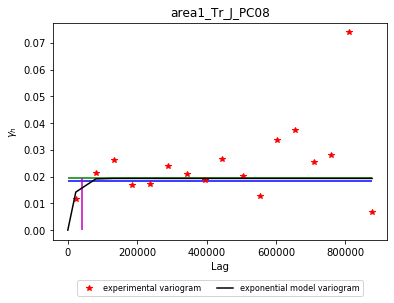

Calculating statistics on variogram model fit...
PC09
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.010536687353472348
Full Sill: 0.010536687353472348
Range: 52000
Nugget: 0.0 



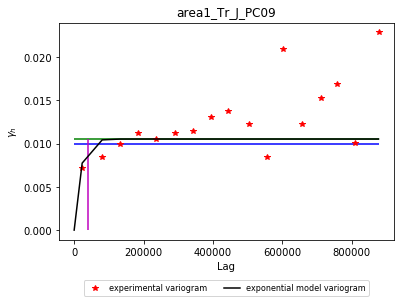

Calculating statistics on variogram model fit...
PC10
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 0.004037443724055215
Full Sill: 0.004037443724055215
Range: 100000
Nugget: 0.0 



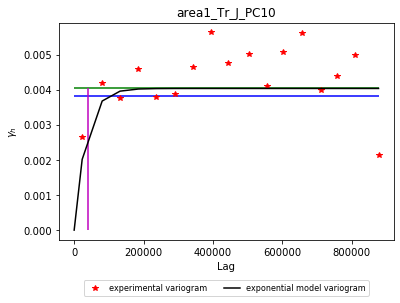

Calculating statistics on variogram model fit...
Wall time: 3.76 s


In [131]:
%%time
# Initialize empty dictionary
variograms = {}

# Loop though the diiferent principal components
for component in mineralogy_pca_df.columns.tolist()[:-1]:
    print(component)
    # Subset principal component to use
    data = mineralogy_pca_df.loc[:, component].values
    variograms[component] = \
        OrdinaryKriging(X, Y, data,
                        variogram_model='exponential',
                        variogram_parameters=variogram_model_parameters[component],
                        nlags=n_lags,
                        verbose=True,
                        enable_statistics=False,
                        enable_plotting=True,
                        weight=True,
                        saveplot=True,
                        coordinates_type='euclidean',
                        saveloc="../_FIGURES/variograms/",
                        principal_component=component,
                        pluton=group_name,
                        show_nlag_pairs=False, # Turn off displaying number of lag pairs in lag bin
                        show_range_determine_guide=True, # 0.95 * sill highlighted with blue line to help determining range
                        range_estimate=40000) # Pass in value in meters to display a line at range estimate; set value to None to not display line
    
# NOTE that ideally Q1 is close to zero, Q2 is close to 1, and cR is as small as possible.

## Leave One Out Cross Validation (LOOCV) of PCA
____

In [132]:
# If you have run the cross validation before you can load the results by
# running this cell and don't have to run the next cell anymore.
CV_results = preproc.load_obj("CV_results_fast")

In [133]:
# Use this cross validation to check the hyper-parameters of your chosen variogram model 
# such as the search_radius, variogram_model, lag_bins etc.

# Cross validation parameter dictionary to use
# You can remove or add options here which will decrease or increase the number 
# of combinations of parameters the cross validation will run
cv_param_dict = {}

for component in mineralogy_pca_df.columns.tolist()[:-1]:
    cv_param_dict[component] = {"method": ["ordinary"],
                                "variogram_model": ["exponential", "spherical"],
                                "variogram_model_parameters": [variogram_model_parameters[component]],
                                "nlags": [n_lags],
                                "weight": [True],
                                "n_closest_points": [number_of_control_points],
                                "search_radius": [range_[0]]
                                }

# The CV function below uses parallel processing to speed things up
# Your CPU will thus reach 100% probably
# To reduce the number of parallel processes to use you can change the following value
# Defaults to -1 to use all available CPU cores; change to number between 1 and 8 e.g. 
# depending on how many cores your CPU has
n_jobs = -1 

In [134]:
%%time
# Run CV and get estimators (using default MSE scorer)

# Instead of running the CV for all the PCs, let's start with only the first 3 
# to get an idea of what are the best parameters to use for the first 3 PCs.
# In a later step we can then obtain the best parameters for all PCs that have 
# a sensible variogram; here this would mean up to and including PC09.
# To specify which PCs to use, you can pass them in as list to the 'components_to_use' variable

# Another change I've made, is that instead of performing leave-one-out-CV 
# where the train set is equal to n_sample - 1 and the test set is equal to 1,
# it makes sense to here use a different strategy, since you're dealing with many more samples.
# Therefore I've included the 'cv_folds' parameter where you can specify 
# the number of train/test groups you want to use during CV
# Let's start with ten groups, which basically means that 
# you use 90% of the samples as train set and 10% as test test
# and this in 10 combinations.

# A a later stage we could change the CV to use a statified cv_fold
# meaning that it ensures for example that for every train/test grouping of the 10 groups
# equal numbers of samples of spcified grouping variable are used 
# (for example your time category or classification later on)

# I've also included the '%%time' statement at the beginning of the cell,
# so that at the end of the calculation you can see how much time it took.

# Have a look here if you want some background info on the CV method used:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

estimators = loocv.perform_loocv(mineralogy_pca_df,
                                 coordinates_utm,
                                 cv_param_dict,
                                 n_jobs=n_jobs,
                                 cv_folds=10,
                                 components_to_use=[f"PC0{i}" for i in range(1, 10)])

PC01
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    3.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.3s finished
C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\sklearn\model_selection\_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC02
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC03
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished


PC04
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC05
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC06
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC07
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC08
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


PC09
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished


Wall time: 9 s


In [135]:
# Convert estimators to dict of dataframes
CV_results = loocv.convert_scores_to_df(estimators)

In [136]:
# Save CV_results to pickle file for easy use later
# These are the results from the 56min CV above (with only first 3 PCs)
preproc.save_obj(CV_results, "CV_results_summarized")

In [137]:
# Save CV_results to pickle file for easy use later
# These are the results from the 2min CV above (with only first 9 PCs, simple parameters)
preproc.save_obj(CV_results, "CV_results_fast")

In [138]:
# Quick look at best results per PC
loocv.print_best_scores(CV_results)

PC01
rank_test_score                    2
mean_test_score             0.817396
std_test_score              0.361207
mean_train_score                   0
param_method                ordinary
param_variogram_model    exponential
param_search_radius            52000
Name: 0, dtype: object


PC02
rank_test_score                    2
mean_test_score             0.587113
std_test_score              0.287086
mean_train_score                   0
param_method                ordinary
param_variogram_model    exponential
param_search_radius            52000
Name: 0, dtype: object


PC03
rank_test_score                    2
mean_test_score             0.370398
std_test_score             0.0900977
mean_train_score                   0
param_method                ordinary
param_variogram_model    exponential
param_search_radius            52000
Name: 0, dtype: object


PC04
rank_test_score                    2
mean_test_score             0.332561
std_test_score              0.104424
mean_train_score 

## Calculating predictions for best model
____

In [139]:
# Here you can specify the components and search_radii you want to use 
# when performing the kriging and performing the postprocessing calculations
components_to_use = [f"PC{i:02d}" for i in range(1, 10)]
search_radii = [range_[0]]

In [140]:
estimators_final = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates"]:

            estimators_final[f"{component}_{radius}_{variable_to_fit}"] = \
                Krige(method='ordinary',
                      variogram_model=variogram_model,
                      variogram_model_parameters=variogram_model_parameters[component],
                      nlags=n_lags,
                      weight=True,
                      n_closest_points=number_of_control_points,
                      search_radius=radius,
                      variable_to_fit=variable_to_fit)

In [141]:
# Run this cell if you have previously run the next cell and saved its outcome
kriging_predictions = preproc.load_obj(f"kriging_predictions_{group_name}")

In [142]:
%%time
# You can again change the n_jobs to lower the #CPU cores used for parallel processing
# Also set the cv_folds variable below
cv_folds = 10

kriging_predictions = {}

for component in components_to_use:  # Changed to only first 9 PCs
    for radius in search_radii:  # Removed critical_distance
        for variable_to_fit in ["estimates"]:  # Removed 'variances'
            
            # Let's print out the combination to see where we are in the loops
            print(component, radius, variable_to_fit)
            
            kriging_predictions[f"{component}_{radius}_{variable_to_fit}"] = \
                cross_val_predict(estimators_final[f"{component}_{radius}_{variable_to_fit}"], 
                                  X=np.stack((coordinates_utm["X"],
                                              coordinates_utm["Y"]), axis=1),
                                  y=mineralogy_pca_df[component],
                                  cv=cv_folds,
                                  n_jobs=4,
                                  verbose=5)

PC01 52000 estimates


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    2.0s remaining:    1.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PC02 52000 estimates
PC03 52000 estimates
PC04 52000 estimates


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


PC05 52000 estimates
PC06 52000 estimates
PC07 52000 estimates
PC08 52000 estimates
PC09 52000 estimates
Wall time: 3.17 s


[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


In [143]:
preproc.save_obj(kriging_predictions, f"kriging_predictions_{group_name}")

## Calculate clr solutions
____

In [144]:
kriging_estimates_df = {}

for radius in search_radii:
    temp = {}
    
    for component in components_to_use:
        key = f"{component}_{radius}_estimates"
        temp[key] = kriging_predictions[key]

    kriging_estimates_df[f"{radius}"] = pd.DataFrame.from_dict(temp)
    kriging_estimates_df[f"{radius}"].index = mineralogy_pca_df.index
    kriging_estimates_df[f"{radius}"].columns = components_to_use
    
    print(f"{radius}")
    kriging_estimates_df[f"{radius}"].head()

52000


,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09
35,0.198540,-0.023278,0.476007,-0.420820,-0.223036,-0.201933,0.136295,0.078436,-0.133353
36,-0.495949,-0.121978,0.315129,-0.177596,-0.330456,-0.646349,0.146104,0.098654,-0.098936
65,0.466582,-0.592724,-0.412928,0.043460,0.027952,-0.288174,-0.051041,0.068365,-0.137375
73,-0.434479,-0.114254,-0.855604,-0.721962,0.284918,-0.144932,0.578136,0.023590,0.027911
124,-0.693953,0.107074,-0.856356,-0.068135,-0.305845,-0.392374,0.835592,-0.050223,0.155726


In [145]:
kriging_estimates_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        kriging_estimates_clr[f"{ncomp}_{radius}"] = \
            postproc.reverse_pca(mineralogy_pca, 
                                 kriging_estimates_df[f"{radius}"],
                                 mineralogy_clr,
                                 n_comp=ncomp)

In [146]:
solutions_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        solutions_clr[f"{ncomp}_{radius}"] = \
            pd.DataFrame(kriging_estimates_clr[f"{ncomp}_{radius}"], 
                         index=mineralogy_clr.index, 
                         columns=mineralogy_clr.columns)

In [147]:
residuals_clr = {}

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        residuals_clr[f"{ncomp}_{radius}"] = \
            mineralogy_clr.subtract(solutions_clr[f"{ncomp}_{radius}"])

In [148]:
for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:
        temp = pd.merge(residuals_clr[f"{ncomp}_{radius}"], 
                        pd.DataFrame(nvalues_control_points[radius], 
                                     columns=["n_closest_points"]), 
                        left_index=True, 
                        right_index=True)\
                 .sort_values("n_closest_points")
        
        temp.to_excel(f"../_RESULTS/Residuals/residuals_clr_{ncomp}_{radius}_{group_name}.xlsx")

In [149]:
preproc.save_obj(residuals_clr, f"residuals_clr_{group_name}")

In [150]:
preproc.save_obj(nvalues_control_points, f"nvalues_control_points_{group_name}")

## Model selection

In [151]:
# Get MSPE_Q values and select best model based on it
# Make sure the selected model passes the Hotelling's T² 2-sample test above, though
MSPE_Q = {}
best_MSPE_Q = 1000

for ncomp in range(1, len(components_to_use) + 1):
    for radius in search_radii:

        # Calculate MSPE_Q from clr residuals
        MSPE_Q_temp = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0)

        if MSPE_Q_temp < best_MSPE_Q:
            # Store best MSPE_Q en corresponding model
            best_MSPE_Q = MSPE_Q_temp
            selected_model = f"{ncomp}_{radius}"

        MSPE_Q[f"{ncomp}_{radius}"] = MSPE_Q_temp
                
MSPE_Q
best_MSPE_Q
selected_model
selected_model_PCs = selected_model.split("_")[0]

{'1_52000': 2.495856882681375,
 '2_52000': 2.559744224116643,
 '3_52000': 2.608687176221837,
 '4_52000': 2.6834779995752247,
 '5_52000': 2.7438621013972866,
 '6_52000': 2.773684824279304,
 '7_52000': 2.7887201154098435,
 '8_52000': 2.794962894506285,
 '9_52000': 2.796806952629495}

2.495856882681375

'1_52000'

In [152]:
# Number of PCs to use for reverse calculations based on selected model
n_comp = int(selected_model.split("_")[0])
# Whcih PCs to use moving forward
selected_components_to_use = [f"PC{i:02d}" for i in range(1, n_comp + 1)]

In [153]:
selected_components_to_use

['PC01']

## Contour plots
____

In [154]:
nvalues_critical_distance = \
    variograms["PC01"].determine_mask_array(grid[0], 
                                            grid[1], 
                                            search_radius=critical_distance)
mask_critical_distance = nvalues_critical_distance < 3
mask_critical_distance.shape

(298, 2)
(222794, 2)
494 451


(451, 494)

In [155]:
mask_critical_distance[mask_critical_distance == 1].sum()

172349

In [156]:
non_masked_grid_nodes = \
    grid[0].shape[0] * grid[1].shape[0] \
    - mask_critical_distance[mask_critical_distance == 1].sum()

In [157]:
grid_cell_spacing = grid[0][1] - grid[0][0]
grid_cell_area = grid_cell_spacing ** 2

In [158]:
# Pluton area in m²
pluton_area_m2 = non_masked_grid_nodes * grid_cell_area

# Pluton area in km²
pluton_area_km2 = pluton_area_m2 / 1_000_000

In [159]:
pluton_area_km2

147350.92155648873

____

In [160]:
interpolated_dict = preproc.load_obj(f"interpolated_dict_{group_name}")

FileNotFoundError: [Errno 2] No such file or directory: '../_DATA/_obj/interpolated_dict_area1_Tr_J.pkl'

In [ ]:
# Since my desktop (with 32GB of RAM) ran out of memory,
# I've reduced the grid spacing so that there are fewer grid points 
# to perform the interpolation for

# You could also reduce the number of active CPU cores by decreasing 'n_jobs'
# which would reduce memory consumption
# so that you could still get a more detailed interpolation grid.
# The interpolation will take a bit longer than since 
# not the maximum number of 'workers' can be used in that case.

### remark
cell below was changed -->  changed it for all the other areas also

In [161]:
%%time
interpolated_parallel = Parallel(n_jobs=1)(delayed(
    variograms[component].execute)('masked', 
                     grid[0], 
                     grid[1],
                     mask_critical_distance,
                     n_closest_points=number_of_control_points, 
                     search_radius=range_[0], 
                     backend='loop') for component in components_to_use)

Wall time: 2min 41s


In [162]:
interpolated_dict = {}
for i, item in enumerate(interpolated_parallel, start=1):
    interpolated_dict[f"PC0{i}"] = item

In [163]:
preproc.save_obj(interpolated_dict, f"interpolated_dict_{group_name}")

In [164]:
interpolated_array = postproc.convert_grid_to_array_of_scores(interpolated_dict)

interpolated_reverse_pca = postproc.reverse_pca(mineralogy_pca, 
                                                interpolated_array, 
                                                mineralogy_clr, 
                                                n_comp=n_comp)

interpolated_reverse_clr = postproc.reverse_clr(interpolated_reverse_pca, 
                                                mineralogy_clr)


# You will get a FutureWarning here, that's fine

1
2
3
4
5
6
7
8
9
(9, 451, 494)


C:\Users\Sebastian\Anaconda3\envs\main\lib\site-packages\IPython\core\interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [165]:
# Get kriging surface variance for error_budget
var_OK = np.array(pd.DataFrame(interpolated_array).var(axis=0, ddof=1))
var_OK.sum()

1.1224086428288407

In [166]:
# Check if the number of points based on the specified grid is equal to
# the sum of the number of masked points and the number of interpolated points
assert grid[0].shape[0] * grid[1].shape[0] == np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 0.0)) + \
                                              np.sum(np.isclose(interpolated_reverse_clr.sum(axis=1), 100.0))

In [167]:
interpolated_modal = {}
for mineral in interpolated_reverse_clr.columns.tolist():
    interpolated_modal[mineral] = np.reshape(interpolated_reverse_clr.loc[:, mineral].values, 
                                             (grid[1].shape[0], grid[0].shape[0]))

In [168]:
# If you get an error related to an non-esixting save location
# Please first create a folder on your pc with the same name that 
# you used for the variable 'group_name'

for mineral, interpolation in interpolated_modal.items(): 
    for variable in ["estimates"]:
        print(interpolation.shape)
        plots.plot_contour_map(interpolation,
                               grid,
                               coordinates_utm,
                               group_name,
                               variable=variable,
                               title=f"{mineral} radius={range_[0]}m {variable} masked {critical_distance}m",
                               show_plot=False,
                               single_mineral=True,
                               mineral=mineral,                               
                               label_pos = (0.03, 0.94),
                               skip_xaxis_label=2,
                               skip_yaxis_label=2,
                               skip_xaxis_start=1,
                               skip_yaxis_start=1,
                               marker_symbol='.',
                               marker_size=0.1,
                               marker_color='r',)
        
# Added some options to function so that yu can easily change the appearance 
# of the markers used to show the position of the control points

(451, 494)
SiO2
(451, 494)
TiO2
(451, 494)
Al2O3
(451, 494)
Fe2O3
(451, 494)
FeO
(451, 494)
MnO
(451, 494)
MgO
(451, 494)
CaO
(451, 494)
Na2O
(451, 494)
K2O
(451, 494)
oth


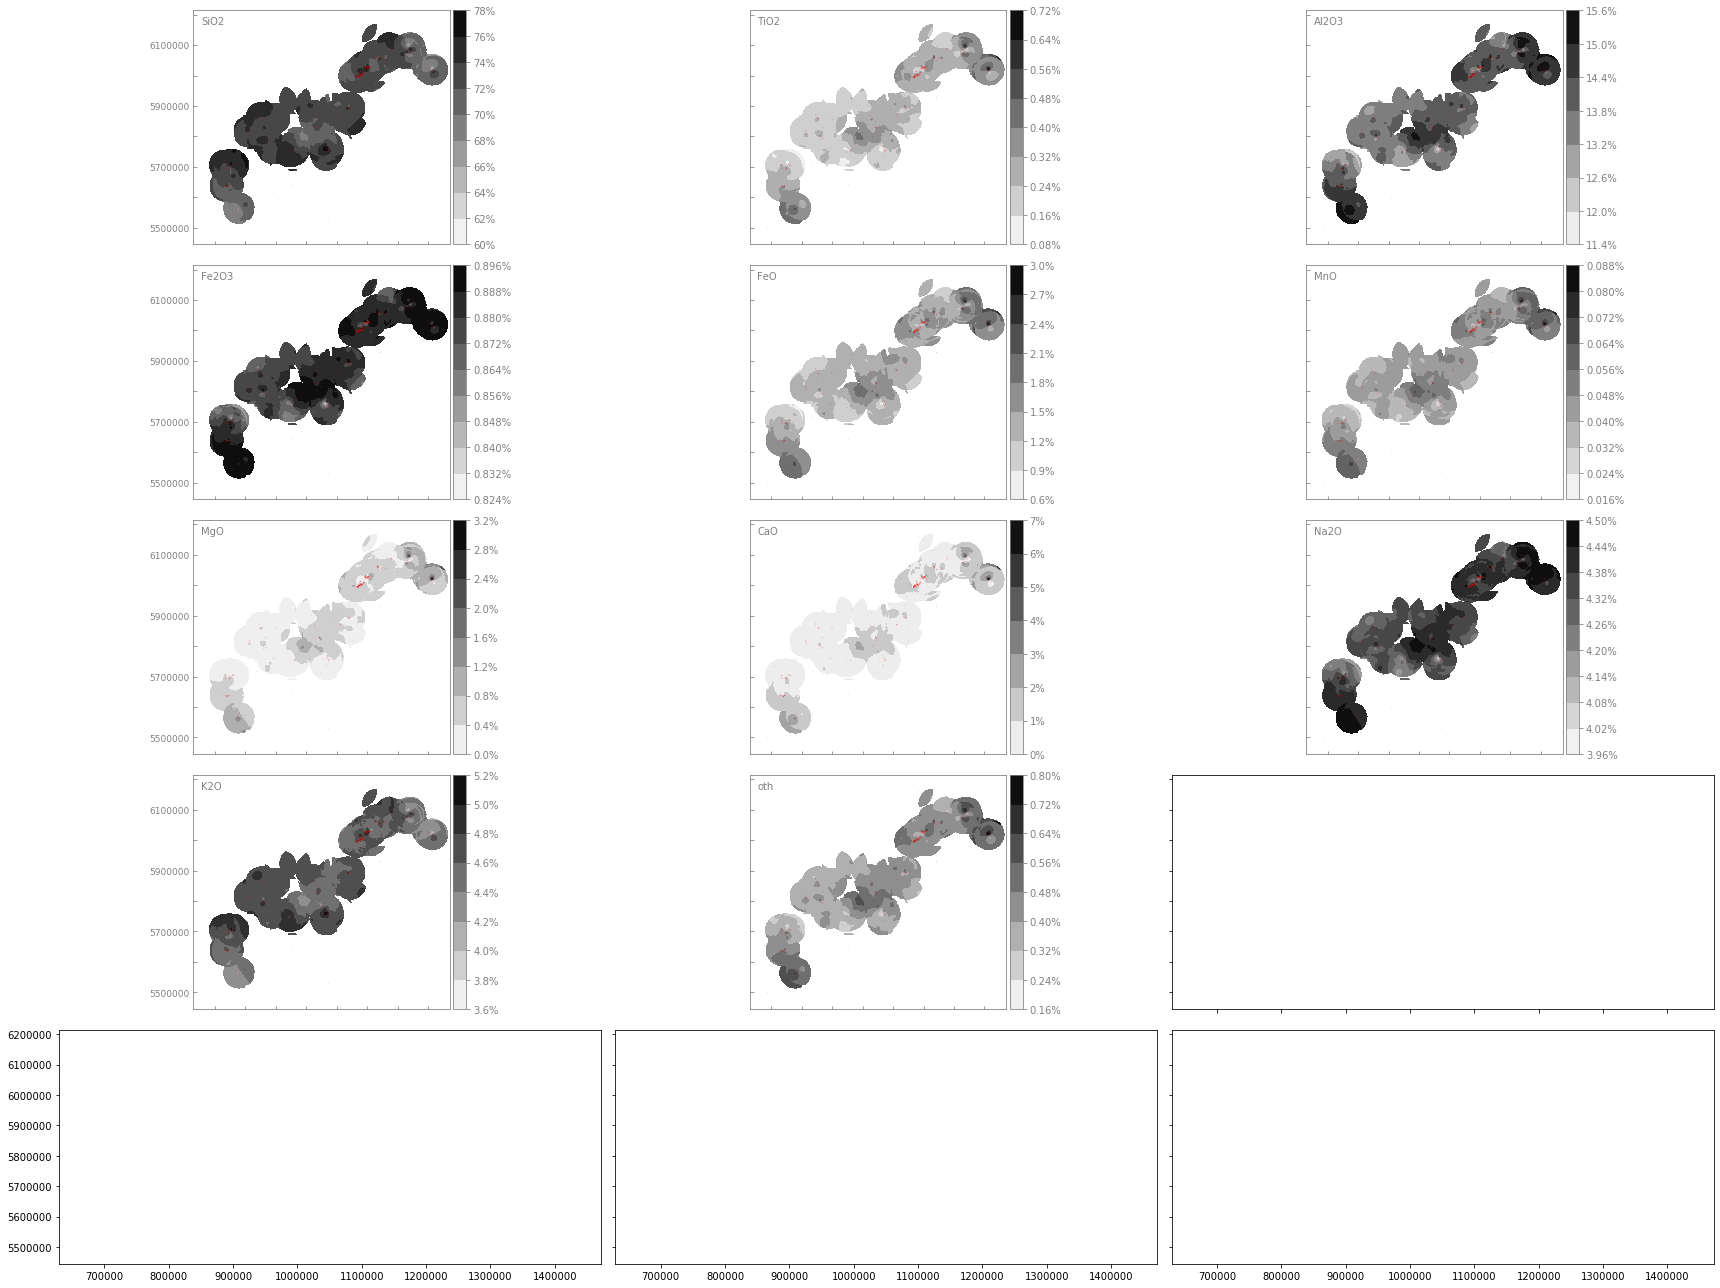

In [169]:
# Specify how many rows and columns you want to use in the following figure
# This will ofcourse depend an the number of variables you would like to plot
# You can also set the figure size
n_cols = 3
n_rows = 5

# Figure with single mineral maps as subplots
plots.plot_contour_map_all(interpolated_modal,
                           grid,
                           coordinates_utm,
                           group_name,
                           title=f"radius={range_[0]}m masked {critical_distance}m",
                           show_plot=True,
                           label_pos = (0.03, 0.94),
                           skip_xaxis_label=2,
                           skip_yaxis_label=2,
                           skip_xaxis_start=1,
                           skip_yaxis_start=1,
                           marker_size=0.1,
                           marker_color='r',
                           marker_symbol='.',
                           figsize=(24, 18),
                           ncols=n_cols,
                           nrows=n_rows,
                           sharex=True,
                           sharey=True)

In [170]:
interpolated_reverse_clr

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,oth
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
222789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## QAPF maps
____

In [180]:
interpolated_mineralogy = pd.read_excel("../_CIPW/CIPW/AREA1_Tr_J/qapf.xlsx")

In [181]:
interpolated_reverse_clr = pd.read_excel("../_CIPW/CIPW/AREA1_Tr_J/interpolated_data.xlsx")

In [182]:
interpolated_mineralogy = interpolated_mineralogy.set_index(" SAMPLE")

In [183]:
interpolated_mineralogy["QAPF_numbers"] = interpolated_mineralogy["QAPF"].map(qapf.QAPF_upper_regions_numbers)

In [184]:
interpolated_mineralogy

,Q,P,K,QAPF,QAPF_numbers
SAMPLE,,,,,
19846,19.054792,43.018048,29.028022,monzo granite,5
19847,19.042517,43.022871,29.024907,monzo granite,5
19848,19.030882,43.027438,29.021900,monzo granite,5
19849,19.019936,43.031750,29.019072,monzo granite,5
20334,19.145943,42.981854,29.051565,monzo granite,5
...,...,...,...,...,...
208816,27.381741,36.855054,31.241367,monzo granite,5
208817,27.407507,36.830765,31.248939,monzo granite,5
208818,27.431187,36.808491,31.255787,monzo granite,5


In [185]:
interpolated_mineralogy_QAPF = pd.merge(interpolated_reverse_clr, interpolated_mineralogy, 
                                        left_index=True, right_index=True, how='outer')\
                                 .drop(interpolated_reverse_clr.columns, axis=1)

interpolated_mineralogy_QAPF = interpolated_mineralogy_QAPF.fillna(0)
interpolated_mineralogy_QAPF

,Q,P,K,QAPF,QAPF_numbers
0,0.0,0.0,0.0,0,0.0
1,0.0,0.0,0.0,0,0.0
2,0.0,0.0,0.0,0,0.0
3,0.0,0.0,0.0,0,0.0
4,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...
222789,0.0,0.0,0.0,0,0.0
222790,0.0,0.0,0.0,0,0.0
222791,0.0,0.0,0.0,0,0.0
222792,0.0,0.0,0.0,0,0.0


In [186]:
interpolated_mineralogy_QAPF_reshape = np.reshape(interpolated_mineralogy_QAPF["QAPF_numbers"].values, (grid[1].shape[0], grid[0].shape[0]))

In [187]:
values_to_plot = list(np.sort(interpolated_mineralogy_QAPF["QAPF_numbers"].unique()))[1:]
values_to_plot

[5.0, 10.0]

In [188]:
# Need to have correct excel file with area's control points' CIPW-QAPF classification
mineralogy_QAPF = pd.read_excel("../_CIPW/CIPW/AREA1_Tr_J/QAPF_control_points.xlsx", index_col=0)

In [189]:
QAPF_to_plot = pd.merge(coordinates_utm, mineralogy_QAPF[["QAPF"]], left_index=True, right_index=True)

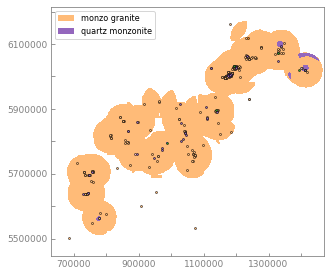

In [190]:
plots.plot_contour_map_interpolated_QAPF(interpolated_mineralogy_QAPF_reshape, grid, QAPF_to_plot, f"{group_name}", values_to_plot=values_to_plot,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=True)

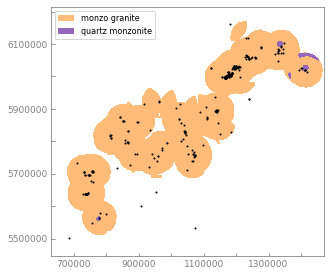

In [191]:
plots.plot_contour_map_interpolated_QAPF(interpolated_mineralogy_QAPF_reshape, grid, QAPF_to_plot, f"{group_name}", values_to_plot=values_to_plot,
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=False, no_legend=False)

## Cluster analysis maps
____

**I was doubting what would make more sense:**  
  - **Perform the interpolation and use these values to perform the cluster analysis OR**
  - **Perform the cluster analysis on the control points and interpolate those values to obtain cluster analysis of grid points.**  
  
**I believe the first option makes more sense (and so that's what I persued below) but it is something we could discuss with Gert Jan.**

In [127]:
# Create mockup cluster analysis classification as an example
interpolation_array = np.random.randint(2, 6, size=interpolated_reverse_clr.shape[0])
# Replace NaN values with zero
interpolation_array[interpolated_reverse_clr["SiO2"].isnull().values] = 0
# Reshape array to grid dimensions
interpolation_array = interpolation_array.reshape((grid[1].shape[0], grid[0].shape[0]))

# Merged mockup cluster analysis classification of control points with coordinates DataFrame
control_points_cluster = pd.merge(coordinates_utm, pd.DataFrame(np.random.randint(2, 6, size=mineralogy_clr.shape[0])), 
                                  left_index=True, right_index=True)

In [129]:
# Probably will need to modify code a bit to match your exact input but basically the input cluster column/array should not contain ones
# This is to mark the boundary between the NaN/zero values and true values within the code more distinctly.
# So you could have an additional step to your 'interpolation_array' by adding 1 to every value before setting the NaNs to zero.

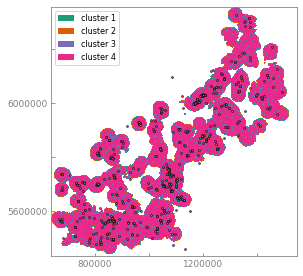

In [139]:
# Function call is very similar to the one for the QAPF maps
plots.plot_contour_map_interpolated_cluster(interpolation_array, grid, control_points_cluster, f"{group_name}", values_to_plot=range(2, 6),
                                         skip_xaxis_label=2, skip_yaxis_label=2, skip_xaxis_start=1, skip_yaxis_start=1, show_qapf_control_points=True, no_legend=False)

## Biplots
____

Not relevant for now

## Simulations
____

Not relevant for now

## Error budget
____

In [171]:
# A = Variance of kriging surface
# B = mean squared prediction error (MSPE)
# C = Sum of nugget
# D = Total variance based on simulation (not yet available)
# E = Variance of original data set

error_budget = {}

for radius in search_radii:
    for ncomp in range(1, len(components_to_use) + 1):
        A = var_OK[:ncomp].sum()
        B = np.mean(np.sum(residuals_clr[f"{ncomp}_{radius}"] ** 2, axis=1), axis=0) # MSPE
        C = np.array(nugget_)[:ncomp].sum()
        D = np.nan
        E = mineralogy_clr.var(axis=0).sum()
        

        error_budget[f"{ncomp}_{radius}"] = [A, B, C, D, E]

In [172]:
error_budget_df = \
    ttest.convert_summary_test_results_to_df(error_budget, 
                                             variable_names=["VAR(OK)",
                                                             "MSPE", 
                                                             "S_nugget", # Sum of nuggets
                                                             "VAR(TOTAL)",
                                                             "VAR(DATA)"], 
                                             order=["search_radius", 
                                                    "#PCs"])
error_budget_df

,search_radius,#PCs,VAR(OK),MSPE,S_nugget,VAR(TOTAL),VAR(DATA)
0,52000,1,0.349841,2.495857,0.0,NaN,2.444146
1,52000,2,0.625532,2.559744,0.0,NaN,2.444146
2,52000,3,0.742592,2.608687,0.0,NaN,2.444146
3,52000,4,0.835458,2.683478,0.0,NaN,2.444146
4,52000,5,0.924041,2.743862,0.0,NaN,2.444146
5,52000,6,1.044926,2.773685,0.0,NaN,2.444146
6,52000,7,1.105143,2.788720,0.0,NaN,2.444146
7,52000,8,1.117624,2.794963,0.0,NaN,2.444146
8,52000,9,1.122409,2.796807,0.0,NaN,2.444146


In [173]:
error_budget_df.to_excel(f"../_RESULTS/Error_budget/error_budget_{group_name}.xlsx")

------

## variance for each time class

In [174]:
metadata

,type_granite,time,massif,sampler,others,sampler+year
35,Granite leucocratic,Tr-J,Upper-Balyagin massif,R.P.Kopnova,NaN,"A.K.Izvekov,1968"
36,Granite porphyraceous,Tr-J,Taidut massif,A.I.Fedorova,NaN,"V.I.Sizykh,1967"
65,Granite alkaline,Tr-J,Kontalakan-Marektin massif,N.P.Mel'nikova,NaN,"V.S.Ivanov,1968"
73,Granite-porphyry,Tr-J,NaN,NaN,NaN,"D.V.Trunev,1962"
124,Granite leucocratic,Tr-J,NaN,NaN,NaN,"N.P.Mikhno,1966"
...,...,...,...,...,...,...
3987,Granosyenite porphyraceous,Tr-J,NaN,D.MShuster,NaN,"V.P.Kuznetsov,1960"
4014,Bt granosyenite(granite) porphyraceous,Tr-J,NaN,N.A.Lebedeva,NaN,"V.S.Ivanov,1968"
4078,Bt granite,Tr-J,NaN,L.A.Izarenko,NaN,"E.E.Zelensky,1966"
4220,Granodiorite,Tr-J,NaN,N.A.Lebedeva,NaN,"S.P.Smelovsky,1971"


In [175]:
metadata['time'].value_counts()

Tr-J    298
Name: time, dtype: int64

In [176]:
mineralogy_clr1 = mineralogy_clr.loc[metadata['time'] == 'J']
mineralogy_clr2 = mineralogy_clr.loc[metadata['time'] == 'Tr']
mineralogy_clr3 = mineralogy_clr.loc[metadata['time'] == 'Tr-J']
mineralogy_clr4 = mineralogy_clr.loc[metadata['time'] == 'Mz']
mineralogy_clr5 = mineralogy_clr.loc[metadata['time'] == 'K']


In [177]:
print('variance for subset J is' ,  mineralogy_clr1.var(axis=0).sum())
print('variance for subset Tr is' ,  mineralogy_clr2.var(axis=0).sum())
print('variance for subset Tr-J is' ,  mineralogy_clr3.var(axis=0).sum())
print('variance for subset Mz is' ,  mineralogy_clr4.var(axis=0).sum())
print('variance for subset K is' ,  mineralogy_clr5.var(axis=0).sum())


variance for subset J is 0.0
variance for subset Tr is 0.0
variance for subset Tr-J is 2.444145834269307
variance for subset Mz is 0.0
variance for subset K is 0.0


------

In [178]:
interpolated_reverse_clr.to_excel("../_CIPW/CIPW/AREA1_Tr_J/interpolated_data.xlsx")

In [179]:
interpolated_reverse_clr

,SiO2,TiO2,Al2O3,Fe2O3,FeO,MnO,MgO,CaO,Na2O,K2O,oth
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
222789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
